In [36]:
# 对train过程中计算的所有训练pixel的residual统计。
import os
import numpy as np
import matplotlib.pyplot as plt

step = 10000

all_residual_file_name = f'all_training_{step}_steps_all_residual.npy'
all_residual = np.load('./fit_gmm_model/' + all_residual_file_name)

print(all_residual.shape)

(23242464, 3)


In [10]:
# 如果直接对所有residual进行拟合，那么GMM模型就会根据residual的分布，即数量进行拟合。
# 根据residual在每个分段的residual和，可能效果更好，因为会更明显。
from sklearn.mixture import GaussianMixture
from sklearn.utils.validation import check_is_fitted
import jax.numpy as jnp
# 拟合GMM模型
str_to_num = {'full': 0, 'tied': 1, 'diag': 2, 'spherical': 3}
gmm_means = []
gmm_covariances = []
gmm_weights = []
gmm_precisions_cholesky = []
gmm_covariance_type = []


## 用 image_direct_gmm_fitting 方法：
if False:
  for i in range(all_residual.shape[-1]):  ## 应该是 3 才对
    gmm_model = GaussianMixture(n_components=2, max_iter=100,tol=1e-2,reg_covar=5e-4)
    gmm_model.fit(all_residual[..., i].reshape(-1, 1))
    ## 计算gmm的均值 方差
    gmm_means.append(gmm_model.means_)
    gmm_covariances.append(gmm_model.covariances_)
    gmm_weights.append(gmm_model.weights_)
    gmm_precisions_cholesky.append(gmm_model.precisions_cholesky_)
    assert gmm_model.covariance_type=='full', "gmm_model.covariance_type!='full'"
    gmm_covariance_type.append(str_to_num[gmm_model.covariance_type])
    check_is_fitted(gmm_model)
    print("gmm_means: ", gmm_means)
    print("gmm_covariances: ", gmm_covariances)
    print("gmm_weights: ", gmm_weights)
    print("gmm_precisions_cholesky: ", gmm_precisions_cholesky)
    print("gmm_covariance_type: ", gmm_model.covariance_type)
    
    # 可视化分布曲线
    x = np.linspace(0, 1, 1000)
    pdf = np.exp(gmm_model.score_samples(x.reshape(-1, 1)))
    plt.hist(all_residual, bins=100, density=True, alpha=0.5)
    plt.plot(x, pdf, '-r')
    plt.xlabel('Value')
    plt.ylabel('Probability')
    plt.show()
##
if False:
  str_to_num = {'full': 0, 'tied': 1, 'diag': 2, 'spherical': 3}
  # 对residual的分布划分成小区间进行统计。
  # 定义区间宽度
  interval_width = 0.001
  # 计算区间数量
  num_intervals = int(1 / interval_width)
  
  gmm_means = []
  gmm_covariances = []
  gmm_weights = []
  gmm_precisions_cholesky = []
  gmm_covariance_type = []
  for i in range(all_residual.shape[-1]):  ## 应该是 3 才对
    # 初始化区间内元素总和列表
    all_interval_sums = np.zeros(num_intervals)
    all_hist, all_bin_edges = np.histogram(all_residual[..., i].reshape(-1, 1), bins=np.linspace(0, 1, num_intervals+1))
    # 使用np.digitize将元素分配到区间并计算区间内元素总和
    all_indices = np.digitize(all_residual[..., i].reshape(-1, 1), all_bin_edges)
    for j in range(1, num_intervals+1):
      all_interval_sums[j-1] += np.sum(all_residual[..., i].reshape(-1, 1)[all_indices == j])
    ### 把每个区间的residual的求和(sum)转换成数量。这里对每个区间直接取整，作为数量，可以理解为对residual大的像素个数进行了放大。
    all_interval_sums = all_interval_sums.reshape(-1, 1)
    ids = interval_width*(np.array(range(1,(num_intervals+1)))-0.5).reshape(-1, 1)
    numbers = (all_interval_sums/interval_width).astype(int)
    statistic = []
    for k, id in enumerate(ids):
        tmp = id * np.ones(numbers[k]).reshape(-1,1)
        statistic.append(tmp)
    statistic_all = np.concatenate(statistic)
    # 拟合GMM模型
    # gmm = GaussianMixture(n_components=2, random_state=0)
    gmm_model = GaussianMixture(n_components=2, max_iter=100,tol=1e-2,reg_covar=5e-4)
    gmm_model.fit(statistic_all.reshape(-1, 1))
    ## 计算gmm的均值 方差
    gmm_means.append(gmm_model.means_)
    gmm_covariances.append(gmm_model.covariances_)
    gmm_weights.append(gmm_model.weights_)
    gmm_precisions_cholesky.append(gmm_model.precisions_cholesky_)
    assert gmm_model.covariance_type=='full', "gmm_model.covariance_type!='full'"
    gmm_covariance_type.append(str_to_num[gmm_model.covariance_type])
    check_is_fitted(gmm_model)
    print("gmm_means: ", gmm_means)
    print("gmm_covariances: ", gmm_covariances)
    print("gmm_weights: ", gmm_weights)
    print("gmm_precisions_cholesky: ", gmm_precisions_cholesky)
    print("gmm_covariance_type: ", gmm_model.covariance_type)
    
    # 可视化分布曲线
    x = np.linspace(0, 1, 1000)
    pdf = np.exp(gmm_model.score_samples(x.reshape(-1, 1)))
    plt.hist(all_residual, bins=100, density=True, alpha=0.5)
    plt.plot(x, pdf, '-r')
    plt.xlabel('Value')
    plt.ylabel('Probability')
    plt.show()

##

if True:
  str_to_num = {'full': 0, 'tied': 1, 'diag': 2, 'spherical': 3}
  # 对residual的分布划分成小区间进行统计。
  # 定义区间宽度
  interval_width = 0.001
  # 计算区间数量
  num_intervals = int(1 / interval_width)
  
  gmm_means = []
  gmm_covariances = []
  gmm_weights = []
  gmm_precisions_cholesky = []
  gmm_covariance_type = []
  for i in range(all_residual.shape[-1]):  ## 应该是 3 才对
    # 初始化区间内元素总和列表
    all_interval_sums = np.zeros(num_intervals)
    all_hist, all_bin_edges = np.histogram(all_residual[..., i].reshape(-1, 1), bins=np.linspace(0, 1, num_intervals+1))
    # 使用np.digitize将元素分配到区间并计算区间内元素总和
    all_indices = np.digitize(all_residual[..., i].reshape(-1, 1), all_bin_edges)
    for j in range(1, num_intervals+1):
      all_interval_sums[j-1] += np.sum(all_residual[..., i].reshape(-1, 1)[all_indices == j])
    ### 把每个区间的residual的求和(sum)转换成数量。这里对每个区间直接取整，作为数量，可以理解为对residual大的像素个数进行了放大。
    all_interval_sums = all_interval_sums.reshape(-1, 1)
    ids = interval_width*(np.array(range(1,(num_intervals+1)))-0.5).reshape(-1, 1)
    numbers = (all_interval_sums).astype(int)
    statistic = []
    for k, id in enumerate(ids):
        tmp = id * np.ones(numbers[k]).reshape(-1,1)
        statistic.append(tmp)
    statistic_all = np.concatenate(statistic)
    # 拟合GMM模型
    # gmm = GaussianMixture(n_components=2, random_state=0)
    gmm_model = GaussianMixture(n_components=2, max_iter=100,tol=1e-2,reg_covar=5e-4)
    statistic_all = statistic_all.reshape(-1, 1)
    print("statistic_all.shape: ", statistic_all.shape)
    if statistic_all.shape[0] > 20142016:
      statistic_all = statistic_all[np.random.randint(low = 0, high = statistic_all.shape[0], size = 20142016)]
      print("postprocessing statistic_all.shape: ", statistic_all.shape)
    gmm_model.fit(statistic_all)
    # gmm_model.fit(statistic_all.reshape(-1, 1))
    ## 计算gmm的均值 方差
    gmm_means.append(gmm_model.means_)
    gmm_covariances.append(gmm_model.covariances_)
    gmm_weights.append(gmm_model.weights_)
    gmm_precisions_cholesky.append(gmm_model.precisions_cholesky_)
    assert gmm_model.covariance_type=='full', "gmm_model.covariance_type!='full'"
    gmm_covariance_type.append(str_to_num[gmm_model.covariance_type])
    check_is_fitted(gmm_model)
    # print(f'gmm1 computed in {(time.time() - gmm_start_time):0.3f}s')
    print("gmm_means: ", gmm_means)
    print("gmm_covariances: ", gmm_covariances)
    print("gmm_weights: ", gmm_weights)
    print("gmm_precisions_cholesky: ", gmm_precisions_cholesky)
    print("gmm_covariance_type: ", gmm_model.covariance_type)
    
    # 可视化分布曲线
    x = np.linspace(0, 1, 1000)
    pdf = np.exp(gmm_model.score_samples(x.reshape(-1, 1)))
    plt.hist(all_residual, bins=100, density=True, alpha=0.5)
    plt.plot(x, pdf, '-r')
    plt.xlabel('Value')
    plt.ylabel('Probability')
    plt.show()
  
  gmm_means = jnp.stack(gmm_means)
  gmm_covariances = jnp.stack(gmm_covariances)
  gmm_weights = jnp.stack(gmm_weights)
  gmm_precisions_cholesky = jnp.stack(gmm_precisions_cholesky)
  gmm_covariance_type = jnp.stack(gmm_covariance_type)


statistic_all.shape:  (228837, 1)
gmm_means:  [array([[0.36498741],
       [0.03684142]])]
gmm_covariances:  [array([[[0.03247744]],

       [[0.00204482]]])]
gmm_weights:  [array([0.61315725, 0.38684275])]
gmm_precisions_cholesky:  [array([[[ 5.54892852]],

       [[22.11423949]]])]
gmm_covariance_type:  full


statistic_all.shape:  (194422, 1)
gmm_means:  [array([[0.36498741],
       [0.03684142]]), array([[0.07106992],
       [0.37474351]])]
gmm_covariances:  [array([[[0.03247744]],

       [[0.00204482]]]), array([[[0.00643999]],

       [[0.03105038]]])]
gmm_weights:  [array([0.61315725, 0.38684275]), array([0.46817939, 0.53182061])]
gmm_precisions_cholesky:  [array([[[ 5.54892852]],

       [[22.11423949]]]), array([[[12.46112752]],

       [[ 5.67500919]]])]
gmm_covariance_type:  full


statistic_all.shape:  (148181, 1)
gmm_means:  [array([[0.36498741],
       [0.03684142]]), array([[0.07106992],
       [0.37474351]]), array([[0.3765254 ],
       [0.04341183]])]
gmm_covariances:  [array([[[0.03247744]],

       [[0.00204482]]]), array([[[0.00643999]],

       [[0.03105038]]]), array([[[0.04351122]],

       [[0.00273138]]])]
gmm_weights:  [array([0.61315725, 0.38684275]), array([0.46817939, 0.53182061]), array([0.51971217, 0.48028783])]
gmm_precisions_cholesky:  [array([[[ 5.54892852]],

       [[22.11423949]]]), array([[[12.46112752]],

       [[ 5.67500919]]]), array([[[ 4.7940146 ]],

       [[19.13414613]]])]
gmm_covariance_type:  full


In [11]:
"""Computes gmm mask."""
from typing import Mapping, Tuple

from jax import lax
from jax import device_put
import jax.numpy as jnp
import jax
from jax import random
# from sklearn.mixture import GaussianMixture
import numpy as np
import jax.numpy as jnp
from sklearn.utils.extmath import row_norms


def _asarray_validated(a, check_finite=True,
                       sparse_ok=False, objects_ok=False, mask_ok=False,
                       as_inexact=False):
    """
    Helper function for SciPy argument validation.

    Many SciPy linear algebra functions do support arbitrary array-like
    input arguments. Examples of commonly unsupported inputs include
    matrices containing inf/nan, sparse matrix representations, and
    matrices with complicated elements.

    Parameters
    ----------
    a : array_like
        The array-like input.
    check_finite : bool, optional
        Whether to check that the input matrices contain only finite numbers.
        Disabling may give a performance gain, but may result in problems
        (crashes, non-termination) if the inputs do contain infinities or NaNs.
        Default: True
    sparse_ok : bool, optional
        True if scipy sparse matrices are allowed.
    objects_ok : bool, optional
        True if arrays with dype('O') are allowed.
    mask_ok : bool, optional
        True if masked arrays are allowed.
    as_inexact : bool, optional
        True to convert the input array to a np.inexact dtype.

    Returns
    -------
    ret : ndarray
        The converted validated array.

    """
    if not sparse_ok:
        import scipy.sparse
        if scipy.sparse.issparse(a):
            msg = ('Sparse matrices are not supported by this function. '
                   'Perhaps one of the scipy.sparse.linalg functions '
                   'would work instead.')
            raise ValueError(msg)
    if not mask_ok:
        if np.ma.isMaskedArray(a):
            raise ValueError('masked arrays are not supported')
    toarray = jnp.asarray_chkfinite if check_finite else jnp.asarray
    a = toarray(a)
    if not objects_ok:
        if a.dtype is jnp.dtype('O'):
            raise ValueError('object arrays are not supported')
    if as_inexact:
        if not jnp.issubdtype(a.dtype, jnp.inexact):
            a = toarray(a, dtype=jnp.float_)
    return a


def logsumexp(a, axis=None, b=None, keepdims=False, return_sign=False):
    """Compute the log of the sum of exponentials of input elements.

    Parameters
    ----------
    a : array_like
        Input array.
    axis : None or int or tuple of ints, optional
        Axis or axes over which the sum is taken. By default `axis` is None,
        and all elements are summed.

        .. versionadded:: 0.11.0
    b : array-like, optional
        Scaling factor for exp(`a`) must be of the same shape as `a` or
        broadcastable to `a`. These values may be negative in order to
        implement subtraction.

        .. versionadded:: 0.12.0
    keepdims : bool, optional
        If this is set to True, the axes which are reduced are left in the
        result as dimensions with size one. With this option, the result
        will broadcast correctly against the original array.

        .. versionadded:: 0.15.0
    return_sign : bool, optional
        If this is set to True, the result will be a pair containing sign
        information; if False, results that are negative will be returned
        as NaN. Default is False (no sign information).

        .. versionadded:: 0.16.0

    Returns
    -------
    res : ndarray
        The result, ``np.log(np.sum(np.exp(a)))`` calculated in a numerically
        more stable way. If `b` is given then ``np.log(np.sum(b*np.exp(a)))``
        is returned.
    sgn : ndarray
        If return_sign is True, this will be an array of floating-point
        numbers matching res and +1, 0, or -1 depending on the sign
        of the result. If False, only one result is returned.

    See Also
    --------
    numpy.logaddexp, numpy.logaddexp2

    Notes
    -----
    NumPy has a logaddexp function which is very similar to `logsumexp`, but
    only handles two arguments. `logaddexp.reduce` is similar to this
    function, but may be less stable.

    Examples
    --------
    >>> import numpy as np
    >>> from scipy.special import logsumexp
    >>> a = np.arange(10)
    >>> logsumexp(a)
    9.4586297444267107
    >>> np.log(np.sum(np.exp(a)))
    9.4586297444267107

    With weights

    >>> a = np.arange(10)
    >>> b = np.arange(10, 0, -1)
    >>> logsumexp(a, b=b)
    9.9170178533034665
    >>> np.log(np.sum(b*np.exp(a)))
    9.9170178533034647

    Returning a sign flag

    >>> logsumexp([1,2],b=[1,-1],return_sign=True)
    (1.5413248546129181, -1.0)

    Notice that `logsumexp` does not directly support masked arrays. To use it
    on a masked array, convert the mask into zero weights:

    >>> a = np.ma.array([np.log(2), 2, np.log(3)],
    ...                  mask=[False, True, False])
    >>> b = (~a.mask).astype(int)
    >>> logsumexp(a.data, b=b), np.log(5)
    1.6094379124341005, 1.6094379124341005

    """
    a = _asarray_validated(a, check_finite=False)
    if b is not None:
        a, b = jnp.broadcast_arrays(a, b)
        if jnp.any(b == 0):
            a = a + 0.  # promote to at least float
            # a[b == 0] = -jnp.inf
            # Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`
            a = a.at[b == 0].set(-jnp.inf)

    a_max = jnp.amax(a, axis=axis, keepdims=True)

    if a_max.ndim > 0:
        # a_max[~jnp.isfinite(a_max)] = 0
        # Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`
        # a_max = a_max.at[~jnp.isfinite(a_max)].set(0)
        # 具体化布尔索引
        is_finite_mask = lax.convert_element_type(~jnp.isfinite(a_max), np.int32)
        # 使用具体化的布尔索引进行替换
        a_max = a_max.at[is_finite_mask].set(0)
        
    elif not jnp.isfinite(a_max):
        a_max = 0

    if b is not None:
        b = jnp.asarray(b)
        tmp = b * jnp.exp(a - a_max)
    else:
        tmp = jnp.exp(a - a_max)

    # suppress warnings about log of zero
    with np.errstate(divide='ignore'):
        s = jnp.sum(tmp, axis=axis, keepdims=keepdims)
        if return_sign:
            sgn = jnp.sign(s)
            s *= sgn  # /= makes more sense but we need zero -> zero
        out = jnp.log(s)

    if not keepdims:
        a_max = jnp.squeeze(a_max, axis=axis)
    out += a_max

    if return_sign:
        return out, sgn
    else:
        return out

######
#### 
# Gaussian mixture probability estimators
def _compute_log_det_cholesky(matrix_chol, covariance_type, n_features):
    """Compute the log-det of the cholesky decomposition of matrices.

    Parameters
    ----------
    matrix_chol : array-like
        Cholesky decompositions of the matrices.
        'full' : shape of (n_components, n_features, n_features)
        'tied' : shape of (n_features, n_features)
        'diag' : shape of (n_components, n_features)
        'spherical' : shape of (n_components,)

    covariance_type : {'full', 'tied', 'diag', 'spherical'}

    n_features : int
        Number of features.

    Returns
    -------
    log_det_precision_chol : array-like of shape (n_components,)
        The determinant of the precision matrix for each component.
    """
    # if covariance_type == 0: #"full"
    # assert covariance_type == 0, "covariance_type == \"full\" !"
    n_components, _, _ = matrix_chol.shape
    log_det_chol = jnp.sum(
        jnp.log(matrix_chol.reshape(n_components, -1)[:, :: n_features + 1]), 1
    )

    # elif covariance_type == 1: #"tied"
    #     log_det_chol = jnp.sum(jnp.log(jnp.diag(matrix_chol)))

    # elif covariance_type == 2: #"diag"
    #     log_det_chol = jnp.sum(jnp.log(matrix_chol), axis=1)

    # else:
    #     log_det_chol = n_features * (jnp.log(matrix_chol))

    return log_det_chol

def _estimate_log_gaussian_prob(X, means, precisions_chol, covariance_type):
    """Estimate the log Gaussian probability.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)

    means : array-like of shape (n_components, n_features)

    precisions_chol : array-like
        Cholesky decompositions of the precision matrices.
        'full' : shape of (n_components, n_features, n_features)
        'tied' : shape of (n_features, n_features)
        'diag' : shape of (n_components, n_features)
        'spherical' : shape of (n_components,)

    covariance_type : {'full', 'tied', 'diag', 'spherical'}

    Returns
    -------
    log_prob : array, shape (n_samples, n_components)
    """
    n_samples, n_features = X.shape
    n_components, _ = means.shape
    # The determinant of the precision matrix from the Cholesky decomposition
    # corresponds to the negative half of the determinant of the full precision
    # matrix.
    # In short: det(precision_chol) = - det(precision) / 2
    log_det = _compute_log_det_cholesky(precisions_chol, covariance_type, n_features)

    # if covariance_type == 0: #"full"
    # assert covariance_type == 0, "covariance_type == \"full\" !"
    log_prob = jnp.empty((n_samples, n_components))
    for k, (mu, prec_chol) in enumerate(zip(means, precisions_chol)):
        y = jnp.dot(X, prec_chol) - jnp.dot(mu, prec_chol)
        # log_prob[:, k] = jnp.sum(jnp.square(y), axis=1)
        # Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`
        log_prob = log_prob.at[:, k].set(jnp.sum(jnp.square(y), axis=1))
            

    # elif covariance_type == 1: #"tied"
    #     log_prob = jnp.empty((n_samples, n_components))
    #     for k, mu in enumerate(means):
    #         y = jnp.dot(X, precisions_chol) - jnp.dot(mu, precisions_chol)
    #         log_prob[:, k] = jnp.sum(jnp.square(y), axis=1)

    # elif covariance_type == 2: #"diag"
    #     precisions = precisions_chol**2
    #     log_prob = (
    #         jnp.sum((means**2 * precisions), 1)
    #         - 2.0 * jnp.dot(X, (means * precisions).T)
    #         + jnp.dot(X**2, precisions.T)
    #     )

    # elif covariance_type == 3: #"spherical"
    #     precisions = precisions_chol**2
    #     log_prob = (
    #         jnp.sum(means**2, 1) * precisions
    #         - 2 * jnp.dot(X, means.T * precisions)
    #         + jnp.outer(row_norms(X, squared=True), precisions)
    #     )
    # Since we are using the precision of the Cholesky decomposition,
    # `- 0.5 * log_det_precision` becomes `+ log_det_precision_chol`
    return -0.5 * (n_features * jnp.log(2 * jnp.pi) + log_prob) + log_det


def _estimate_log_weights(weights_):
        return jnp.log(weights_)
    
def _estimate_weighted_log_prob(X, means_, precisions_cholesky_, covariance_type, weights_):
        """Estimate the weighted log-probabilities, log P(X | Z) + log weights.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        Returns
        -------
        weighted_log_prob : array, shape (n_samples, n_component)
        """
        return _estimate_log_gaussian_prob(X, means_, precisions_cholesky_, covariance_type) + _estimate_log_weights(weights_)

def _estimate_log_prob_resp(X, means_, precisions_cholesky_, covariance_type, weights_):
    """Estimate log probabilities and responsibilities for each sample.

    Compute the log probabilities, weighted log probabilities per
    component and responsibilities for each sample in X with respect to
    the current state of the model.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)

    Returns
    -------
    log_prob_norm : array, shape (n_samples,)
        log p(X)

    log_responsibilities : array, shape (n_samples, n_components)
        logarithm of the responsibilities
    """
    weighted_log_prob = _estimate_weighted_log_prob(X, means_, precisions_cholesky_, covariance_type, weights_)
    log_prob_norm = logsumexp(weighted_log_prob, axis=1)
    with np.errstate(under="ignore"):
        # ignore underflow
        log_resp = weighted_log_prob - log_prob_norm[:, jnp.newaxis]
    return log_prob_norm, log_resp

#####################################################

In [12]:
### 验证一下用参数计算的概率和库函数的结果是否一致。
means = gmm_model.means_
covariances = gmm_model.covariances_
weights = gmm_model.weights_
# 新数据点
new_data = jnp.array([0.1, 0.2, 0.5])
new_data = all_residual[:, 0]
# new_data = jnp.random.uniform(0, 1, all_residual.shape[0])
from jax import random
key = random.PRNGKey(256)  # Random seed is explicit in JAX
new_data = random.normal(key, shape=(1000000,))
# new_data[0] = 0
new_data = new_data.at[0].set(0)
new_data = new_data.at[-1].set(1)

print("new_data.min(): ", new_data.min())
print("new_data.max(): ", new_data.max())

# 计算每个新数据点属于每个分量的概率
num_components = len(means)
num_new_data_points = len(new_data)
prob_values = jnp.zeros((num_new_data_points, num_components))

# for i in range(num_components):
#     # 计算多元正态分布的概率密度
#     diff = new_data - means[i]
#     cov = covariances[i]  # 协方差矩阵是1x1的
#     cov_inv = 1.0 / cov  # 计算协方差矩阵的逆
#     exponent = -0.5 * (diff ** 2) / cov  # 计算指数部分
#     pdf_values = (1.0 / jnp.sqrt(2 * jnp.pi * cov)) * jnp.exp(exponent)
#     prob_values[:, i] = pdf_values * weights[i]

# 计算每个新数据点属于所有分量的概率之和并归一化
# total_prob = jnp.sum(prob_values, axis=1)
# normalized_prob_values = prob_values / total_prob[:, jnp.newaxis]
# print("gmm.means_:", gmm_model.means_)
# print("gmm.covariances_:", gmm_model.covariances_)
# print("gmm.weights_:", gmm_model.weights_)
# print("gmm.means_.argmin():", gmm_model.means_.argmin())
# print("每个数据点属于每个分量的概率:\n", normalized_prob_values)

# print("exponent.min():", exponent.min())
# print("exponent.max():", exponent.max())
# print("pdf_values.min():", pdf_values.min())
# print("pdf_values.max():", pdf_values.max())
# print("prob_values.min():", prob_values.min())
# print("prob_values.max():", prob_values.max())
# print("total_prob.min():", total_prob.min())
# print("total_prob.max():", total_prob.max())

prob = gmm_model.predict_proba(new_data.reshape(-1, 1)) 
prob = prob[:, gmm_model.means_.argmin()] 
print("prob:", prob)
print("prob.min():", prob.min())

# prob_my = normalized_prob_values
# prob_my = prob_my[:, gmm_model.means_.argmin()] 
# print("prob_my.min():", prob_my.min())

# error = prob-prob_my
# print(error.max())


#################################### 重写gmm模型的计算函数
from sklearn.utils.validation import check_is_fitted
check_is_fitted(gmm_model)
_, log_resp = _estimate_log_prob_resp(new_data.reshape(-1, 1), gmm_model.means_, gmm_model.precisions_cholesky_, gmm_model.covariance_type, gmm_model.weights_)
prob_my_new = np.exp(log_resp)
print("log_resp.min():", log_resp.min())
print("log_resp.max()", log_resp.max())
sum = np.sum(prob_my_new,axis=-1)
print("sum:", sum)
print("sum.min():", sum.min())
print("sum.max():", sum.max())
prob_my_new = prob_my_new[:, gmm_model.means_.argmin()] 
print("prob_my_new():", prob_my_new)
print("prob_my_new.min():", prob_my_new.min())
print("prob_my_new.max():", prob_my_new.max())

error = prob-prob_my_new
print(error.max())




new_data.min():  -5.419983
new_data.max():  4.913626
prob: [9.30173936e-001 9.34975107e-001 5.47761902e-011 ... 1.35492007e-129
 2.16308165e-131 5.73530317e-071]
prob.min(): 0.0
log_resp.min(): -5076.626
log_resp.max() 0.0
sum: [1. 1. 1. ... 1. 1. 1.]
sum.min(): 0.99999964
sum.max(): 1.0000004
prob_my_new(): [9.3017399e-01 9.3497509e-01 5.4776288e-11 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
prob_my_new.min(): 0.0
prob_my_new.max(): 0.9349751
3.3475345728728456e-07


In [13]:
## 打印出来对应图片看看mask效果
import sys  
sys.path.append('..')  
import os
import numpy as np
from internal import utils
from PIL import Image

import json
from pathlib import Path, PurePath

def load_from_json(filename: Path):
    """Load a dictionary from a JSON filename.

    Args:
        filename: The filename to load from.
    """
    assert filename.suffix == ".json"
    with open(filename, encoding="UTF-8") as file:
        return json.load(file)
# configs 配置路径
data_dir = '/home/wyk/lava2/Model/multinerf/data/and-bot/0'
json_dir = PurePath(data_dir + "/transforms.json")
meta = load_from_json(json_dir)


# Load images.加载图片
image_names = []
for frame in meta["frames"]:
    filepath = PurePath(frame["file_path"])
    fname = filepath
    
    image_names.append(fname)
    
print(image_names.__len__())
# print(image_names)

clutter_images_names = [name for name in image_names if int(name.stem.split('_')[-1])>2000]
print(clutter_images_names.__len__())

images = [utils.load_img(x) for x in clutter_images_names]
images = np.stack(images, axis=0) / 255.


141
122


In [14]:
# prob = gmm.predict_proba(all_residual) 
# prob_min = prob[:,gmm.means_.argmin()] 
# prob_max = prob[:,gmm.means_.argmax()] 
# print("prob_min.shape:", prob_min.shape)
# print("prob_max:", prob_max)
mask = []

for i in range(3):
    resid_sq_ = all_residual[..., i].reshape(-1, 1)
    _, log_resp = _estimate_log_prob_resp(resid_sq_, gmm_means[i], gmm_precisions_cholesky[i], gmm_covariance_type[i], gmm_weights[i])
    normalized_prob_values = jnp.clip(jnp.exp(log_resp), 0.000001, 1.0-0.000001)
    mask_ = jnp.clip(normalized_prob_values[:, gmm_means[i].argmin()], 0.000001, 1.0-0.000001)
    mask.append(mask_)


(122, 378, 504, 3)
RGB residual:
R: 


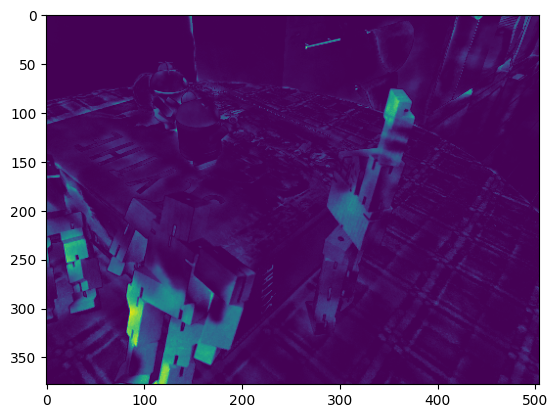

G: 


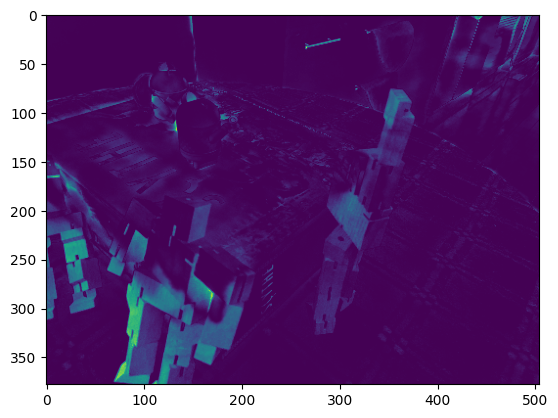

B: 


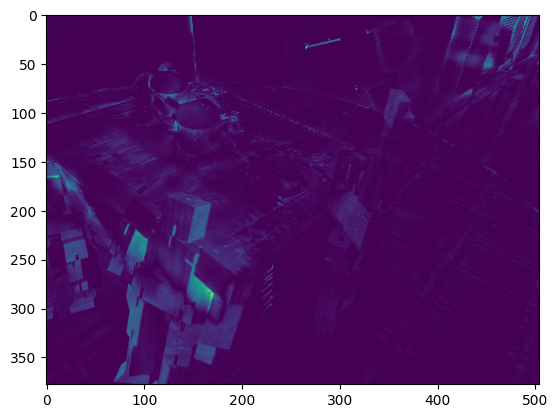

In [40]:
import matplotlib.pyplot as plt

image_id=0
# ## 打印图片看看
# print(images.shape)
# plt.imshow(images[image_id])
# plt.show()

## 3 channels mask
mask_all = 1-jnp.stack(mask, axis=-1)
mask_all = mask_all.reshape(122, 378, 504, 3)
print(mask_all.shape)
# print("3 channels mask:")
# print("R: ")
# plt.imshow(mask_all[image_id][..., 0])
# plt.show()
# print("G: ")
# plt.imshow(mask_all[image_id][..., 1])
# plt.show()
# print("B: ")
# plt.imshow(mask_all[image_id][..., 2])
# plt.show()

### 可视化residual
print("RGB residual:")
print("R: ")
residual_vis = all_residual.reshape(122, 378, 504, 3)
plt.imshow(residual_vis[image_id][..., 0])
plt.show()
print("G: ")
residual_vis = all_residual.reshape(122, 378, 504, 3)
plt.imshow(residual_vis[image_id][..., 1])
plt.show()
print("B: ")
residual_vis = all_residual.reshape(122, 378, 504, 3)
plt.imshow(residual_vis[image_id][..., 2])
plt.show()

# # mean mask
# mask_mean = mask_all.mean(axis=-1, keepdims=True)
# print(mask_mean.shape)
# print("mean mask:")
# plt.imshow(mask_mean[image_id])
# plt.show()

# ## max mask
# mask_max = mask_all.max(axis=-1, keepdims=True)
# print(mask_max.shape)
# print("max mask:")
# plt.imshow(mask_max[image_id])
# plt.show()

# ## min mask
# mask_min = mask_all.min(axis=-1, keepdims=True)
# print(mask_min.shape)
# print("min mask:")
# plt.imshow(mask_min[image_id])
# plt.show()




